# Índice de contenidos
1. Antes de empezar:

2. Reto 1 - Importar y describir el conjunto de datos

    2.0.0.1 Explore el conjunto de datos con técnicas matemáticas y de visualización. ¿Qué encuentra?

3. Reto 2 - Limpieza y transformación de datos

4. Reto 3 - Preprocesamiento de datos

    4.0.0.1 Utilizaremos el StandardScaler de sklearn.preprocessing y escalaremos nuestros datos. Lea más sobre StandardScaler aquí.

5. Reto 4 - Agrupación de datos con K-Means

6. Reto 5 - Agrupación de datos con DBSCAN

7. Reto 6 - Comparar K-Means con DBSCAN

8. Reto adicional 2 - Cambiar el número de clusters de K-Means

9. Bonus Challenge 3 - Cambiar DBSCAN eps y min_samples

# Antes de empezar:
- Lee el archivo README.md
- Comenta todo lo que puedas y utiliza los recursos del archivo README.md
- ¡Feliz aprendizaje!

In [161]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings                                              
from sklearn.exceptions import DataConversionWarning          
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Desafío 1 - Importar y describir el conjunto de datos

En este laboratorio, utilizaremos un conjunto de datos que contiene información sobre las preferencias de los clientes. Analizaremos cuánto gasta cada cliente en un año en cada subcategoría de la tienda de comestibles e intentaremos encontrar similitudes mediante la agrupación.

El origen del conjunto de datos es [aquí](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [162]:
# loading the data: Wholesale customers data
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wholesale_customers = fetch_ucirepo(id=292) 
  
# data (as pandas dataframes) 
X = wholesale_customers.data.features 
y = wholesale_customers.data.targets 

df = pd.concat([X, y], axis=1)

# metadata 
print(wholesale_customers.metadata) 
  
# variable information 
print(wholesale_customers.variables) 

{'uci_id': 292, 'name': 'Wholesale customers', 'repository_url': 'https://archive.ics.uci.edu/dataset/292/wholesale+customers', 'data_url': 'https://archive.ics.uci.edu/static/public/292/data.csv', 'abstract': 'The data set refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 440, 'num_features': 7, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['Region'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2013, 'last_updated': 'Mon Feb 05 2024', 'dataset_doi': '10.24432/C5030X', 'creators': ['Margarida Cardoso'], 'intro_paper': None, 'additional_info': {'summary': None, 'purpose': None, 'funded_by': None, 'instances_represent': None, 'recommended_data_splits': None, 'sensitive_data': None, 'preprocessing_description':

#### Explora el conjunto de datos con técnicas matemáticas y de visualización. ¿Qué encuentras?

Lista de comprobación:

* ¿Qué significa cada columna?
  * Son diferentes productos, excepto channel
* ¿Hay datos categóricos que convertir?
  * Si, Channel y Region
* ¿Hay que eliminar datos que faltan?
  * No
* Colinealidad de columnas: ¿hay correlaciones altas?
  * Si, Grocery con Detergents_Paper
* Estadísticas descriptivas: ¿hay que eliminar algún valor atípico?
  * Si, hay valores outlier en diversas columnas
* Distribución de los datos por columnas: ¿está sesgada la distribución?
  * La distribución en la mayoria de columnas es de tipo exponencial
* Representa el principio de Pareto?
  * No, el 20% de los clientes que mas gastan representan el 42% de las ventas

Información adicional: Hace más de un siglo, un economista italiano llamado Vilfredo Pareto descubrió que aproximadamente el 20% de los clientes representan el 80% de las ventas minoristas típicas. Esto se denomina [principio de Pareto](https://en.wikipedia.org/wiki/Pareto_principle). Compruebe si este conjunto de datos presenta esta característica.

In [163]:
df.head()

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Region
0,2,12669,9656,7561,214,2674,1338,3
1,2,7057,9810,9568,1762,3293,1776,3
2,2,6353,8808,7684,2405,3516,7844,3
3,1,13265,1196,4221,6404,507,1788,3
4,2,22615,5410,7198,3915,1777,5185,3


In [164]:
df.isnull().sum()

Channel             0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
Region              0
dtype: int64

<Axes: >

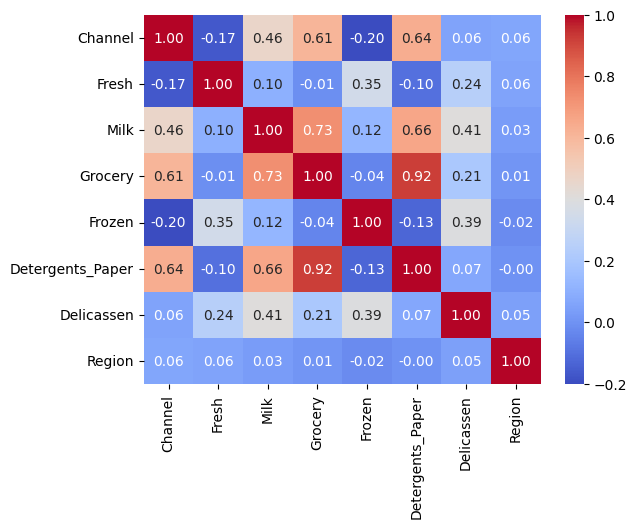

In [165]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")

In [166]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Channel,440.0,1.322727,0.468052,1.0,1.00,1.0,2.00,2.0
Fresh,440.0,12000.297727,12647.328865,3.0,3127.75,8504.0,16933.75,112151.0
Milk,440.0,5796.265909,7380.377175,55.0,1533.00,3627.0,7190.25,73498.0
Grocery,440.0,7951.277273,9503.162829,3.0,2153.00,4755.5,10655.75,92780.0
Frozen,440.0,3071.931818,4854.673333,25.0,742.25,1526.0,3554.25,60869.0
Detergents_Paper,440.0,2881.493182,4767.854448,3.0,256.75,816.5,3922.00,40827.0
Delicassen,440.0,1524.870455,2820.105937,3.0,408.25,965.5,1820.25,47943.0
Region,440.0,2.543182,0.774272,1.0,2.00,3.0,3.00,3.0


In [167]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

outliers = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))

outliers.sum()

Channel              0
Fresh               20
Milk                28
Grocery             24
Frozen              43
Detergents_Paper    30
Delicassen          27
Region               0
dtype: int64

In [168]:
sesgo = df.skew()
sesgo

Channel              0.760951
Fresh                2.561323
Milk                 4.053755
Grocery              3.587429
Frozen               5.907986
Detergents_Paper     3.631851
Delicassen          11.151586
Region              -1.283627
dtype: float64

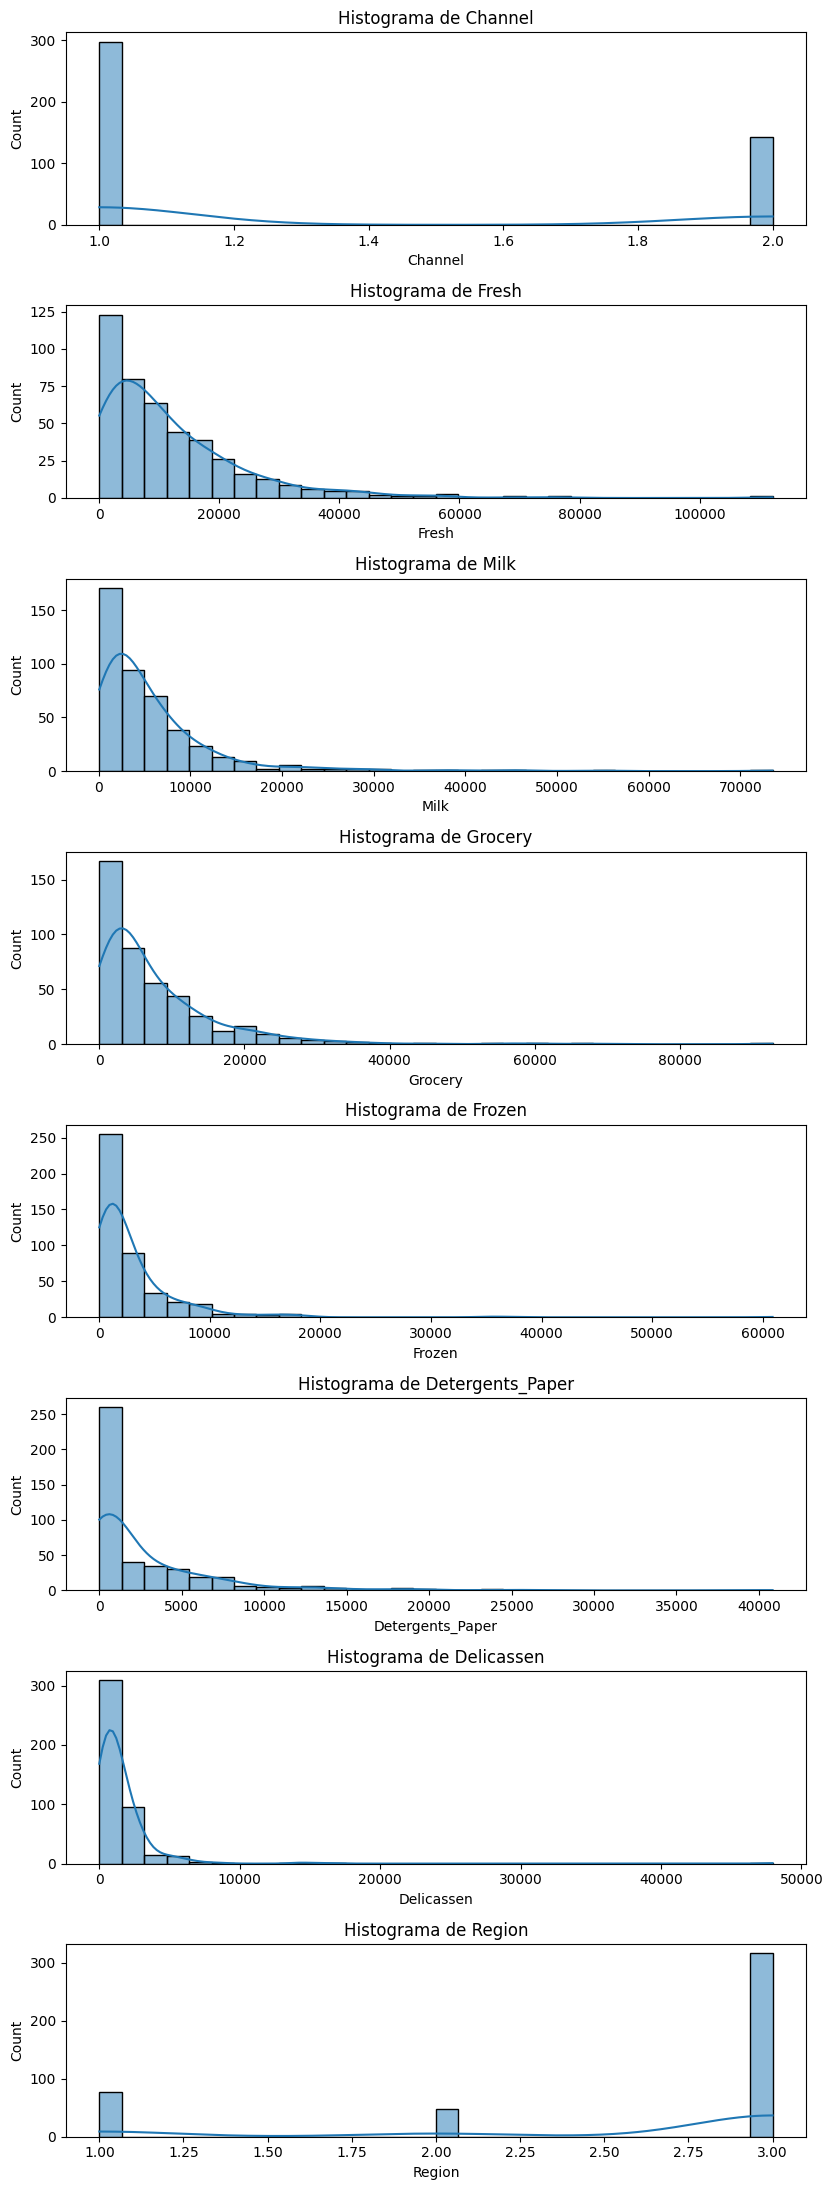

In [169]:
plt.figure(figsize=(16, 22))
for i, column in enumerate(df.columns):
    plt.subplot(len(df.columns), 2, 2*i + 1)
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f'Histograma de {column}')

plt.tight_layout()
plt.show()

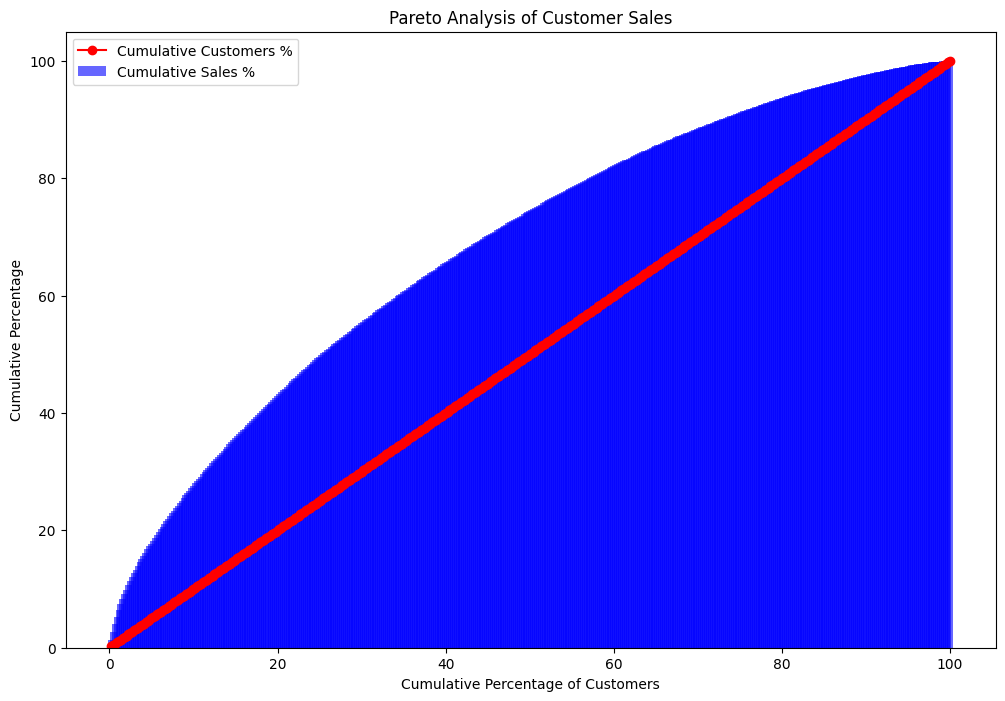

In [170]:
df['total_sales'] = df.sum(axis=1)

# Sort customers by total sales in descending order
df_sorted = df.sort_values(by='total_sales', ascending=False)

# Calculate cumulative percentages
df_sorted['cumulative_sales'] = df_sorted['total_sales'].cumsum()
df_sorted['cumulative_sales_percentage'] = df_sorted['cumulative_sales'] / df_sorted['total_sales'].sum() * 100

df_sorted['cumulative_customers'] = range(1, len(df_sorted) + 1)
df_sorted['cumulative_customers_percentage'] = df_sorted['cumulative_customers'] / len(df_sorted) * 100

# Plot Pareto Chart
plt.figure(figsize=(12, 8))

# Bar plot for cumulative sales
plt.bar(df_sorted['cumulative_customers_percentage'], df_sorted['cumulative_sales_percentage'], color='blue', alpha=0.6, label='Cumulative Sales %')

# Line plot for cumulative customers
plt.plot(df_sorted['cumulative_customers_percentage'], df_sorted['cumulative_customers_percentage'], color='red', marker='o', label='Cumulative Customers %')

plt.xlabel('Cumulative Percentage of Customers')
plt.ylabel('Cumulative Percentage')
plt.title('Pareto Analysis of Customer Sales')
plt.legend()
plt.show()

# Reto 2 - Limpieza y transformación de datos

Si tu conclusión del reto anterior es que los datos necesitan limpieza/transformación, hazlo en las celdas de abajo. Sin embargo, si su conclusión es que los datos no necesitan ser limpiados o transformados, no dudes en saltarte este reto. Si optas por esta última opción, explica los motivos.

* No hay valores missing, por lo tanto en este aspecto podemos saltarnos la limpieza
* Sin embargo si hay valores outlier, y estos si que serán limpiados

In [171]:
df = df[~outliers.any(axis=1)]
df

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Region,total_sales
0,2,12669,9656,7561,214,2674,1338,3,34117
1,2,7057,9810,9568,1762,3293,1776,3,33271
3,1,13265,1196,4221,6404,507,1788,3,27385
5,2,9413,8259,5126,666,1795,1451,3,26715
6,2,12126,3199,6975,480,3140,545,3,26470
...,...,...,...,...,...,...,...,...,...
432,1,21117,1162,4754,269,1328,395,3,29029
433,1,1982,3218,1493,1541,356,1449,3,10043
434,1,16731,3922,7994,688,2371,838,3,32548
438,1,10290,1981,2232,1038,168,2125,3,17838


# Reto 3 - Preprocesamiento de datos

Uno de los problemas del conjunto de datos es que los rangos de valores son notablemente diferentes en las distintas categorías (por ejemplo, `Fresh` y `Grocery` en comparación con `Detergents_Paper` y `Delicassen`). Si hiciste esta observación en el primer reto, ¡has hecho un gran trabajo! Esto significa que no sólo has completado las preguntas de bonificación en el anterior laboratorio de Aprendizaje Supervisado, sino que también has investigado en profundidad sobre [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). ¡Sigue trabajando así de bien!

Diversos rangos de valores en diferentes características podrían causar problemas en nuestra agrupación. La forma de reducir el problema es mediante el escalado de características. Volveremos a utilizar esta técnica con este conjunto de datos.

#### Utilizaremos el `StandardScaler` de `sklearn.preprocessing` y escalaremos nuestros datos. Lee más sobre `StandardScaler` [aquí](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*Después de escalar tus datos, asigna los datos transformados a una nueva variable `customers_scale`.

In [172]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:

scaler = StandardScaler()

customers_scale = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

customers_scale

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Region,total_sales
0,1.579474,0.383041,1.652898,0.334978,-0.967004,0.305053,0.390465,0.590092,0.793903
1,1.579474,-0.305588,1.698756,0.733878,-0.059255,0.569139,0.922591,0.590092,0.724991
2,-0.633122,0.456174,-0.866283,-0.328862,2.662821,-0.619462,0.937169,0.590092,0.245539
3,1.579474,-0.016491,1.236906,-0.148989,-0.701951,-0.069958,0.527749,0.590092,0.190963
4,1.579474,0.316411,-0.269838,0.218508,-0.811022,0.503864,-0.572949,0.590092,0.171006
...,...,...,...,...,...,...,...,...,...
327,-0.633122,1.419665,-0.876407,-0.222926,-0.934752,-0.269195,-0.755184,0.590092,0.379453
328,-0.633122,-0.928323,-0.264181,-0.871064,-0.188850,-0.683883,0.525319,0.590092,-1.167079
329,-0.633122,0.881474,-0.054547,0.421038,-0.689050,0.175783,-0.216984,0.590092,0.666098
330,-0.633122,0.091122,-0.632529,-0.724184,-0.483809,-0.764090,1.346590,0.590092,-0.532126


# Reto 4 - Agrupación de datos con K-Means

Ahora vamos a agrupar los datos con K-Means primero. Inicia el modelo K-Means, luego ajusta tus datos escalados. En los datos devueltos por el método `.fit`, hay un atributo llamado `labels_` que es el número de cluster asignado a cada registro de datos. Lo que puede hacer es asignar estas etiquetas de nuevo a `customers` en una nueva columna llamada `customers['labels']`. Entonces verá los resultados de cluster de los datos originales.

In [173]:
from sklearn.cluster import KMeans

# Your code here:


### Viendo el elbow pododríamos escoger 2 como el número de clusters correctos

In [174]:
kmeans_2 = KMeans(n_clusters=2).fit(customers_scale)

labels = kmeans_2.predict(customers_scale)

clusters = kmeans_2.labels_.tolist()

In [175]:
customers_scale['Label'] = clusters
customers_scale

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Region,total_sales,Label
0,1.579474,0.383041,1.652898,0.334978,-0.967004,0.305053,0.390465,0.590092,0.793903,0
1,1.579474,-0.305588,1.698756,0.733878,-0.059255,0.569139,0.922591,0.590092,0.724991,0
2,-0.633122,0.456174,-0.866283,-0.328862,2.662821,-0.619462,0.937169,0.590092,0.245539,1
3,1.579474,-0.016491,1.236906,-0.148989,-0.701951,-0.069958,0.527749,0.590092,0.190963,0
4,1.579474,0.316411,-0.269838,0.218508,-0.811022,0.503864,-0.572949,0.590092,0.171006,0
...,...,...,...,...,...,...,...,...,...,...
327,-0.633122,1.419665,-0.876407,-0.222926,-0.934752,-0.269195,-0.755184,0.590092,0.379453,1
328,-0.633122,-0.928323,-0.264181,-0.871064,-0.188850,-0.683883,0.525319,0.590092,-1.167079,1
329,-0.633122,0.881474,-0.054547,0.421038,-0.689050,0.175783,-0.216984,0.590092,0.666098,1
330,-0.633122,0.091122,-0.632529,-0.724184,-0.483809,-0.764090,1.346590,0.590092,-0.532126,1


Cuenta los valores en `labels`.

In [176]:
# Your code here:
customers_scale['Label'].count()

332

# Reto 5 - Clustering de datos con DBSCAN

Ahora vamos a agrupar los datos utilizando DBSCAN. Utiliza `DBSCAN(eps=0.5)` para iniciar el modelo y, a continuación, ajusta los datos escalados. En los datos devueltos por el método `.fit`, asigna las `labels_` de nuevo a `customers['labels_DBSCAN']`. Ahora tus datos originales tienen dos etiquetas, una de K-Means y la otra de DBSCAN.

In [177]:
from sklearn.cluster import DBSCAN 

# Your code here
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit the DBSCAN model
dbscan.fit(customers_scale)

# Assign cluster labels to the original DataFrame
customers_scale['Labels_DBSCAN'] = dbscan.labels_
customers_scale

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Region,total_sales,Label,Labels_DBSCAN
0,1.579474,0.383041,1.652898,0.334978,-0.967004,0.305053,0.390465,0.590092,0.793903,0,-1
1,1.579474,-0.305588,1.698756,0.733878,-0.059255,0.569139,0.922591,0.590092,0.724991,0,-1
2,-0.633122,0.456174,-0.866283,-0.328862,2.662821,-0.619462,0.937169,0.590092,0.245539,1,-1
3,1.579474,-0.016491,1.236906,-0.148989,-0.701951,-0.069958,0.527749,0.590092,0.190963,0,-1
4,1.579474,0.316411,-0.269838,0.218508,-0.811022,0.503864,-0.572949,0.590092,0.171006,0,-1
...,...,...,...,...,...,...,...,...,...,...,...
327,-0.633122,1.419665,-0.876407,-0.222926,-0.934752,-0.269195,-0.755184,0.590092,0.379453,1,-1
328,-0.633122,-0.928323,-0.264181,-0.871064,-0.188850,-0.683883,0.525319,0.590092,-1.167079,1,-1
329,-0.633122,0.881474,-0.054547,0.421038,-0.689050,0.175783,-0.216984,0.590092,0.666098,1,-1
330,-0.633122,0.091122,-0.632529,-0.724184,-0.483809,-0.764090,1.346590,0.590092,-0.532126,1,-1


Cuenta los valores en `labels_DBSCAN`.

In [178]:
# Your code here
customers_scale['Labels_DBSCAN'].count()

332

# Reto 6 - Comparar K-Means con DBSCAN

Ahora queremos comparar visualmente cómo K-Means y DBSCAN han agrupado nuestros datos. Crearemos gráficos de dispersión para varias columnas. Para cada uno de los siguientes pares de columnas, traza un gráfico de dispersión utilizando `labels` y otro utilizando `labels_DBSCAN`. Ponlos uno al lado del otro para compararlos. ¿Qué algoritmo de agrupación tiene más sentido?

Columnas a visualizar:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualice `Detergentes_Papel` como X y `Leche` como Y mediante `labels` y `labels_DBSCAN` respectivamente

In [208]:
def plot(x, y, hue):
    
    sns.scatterplot(x=x, y=y, hue=hue)
    
    return plt.show();

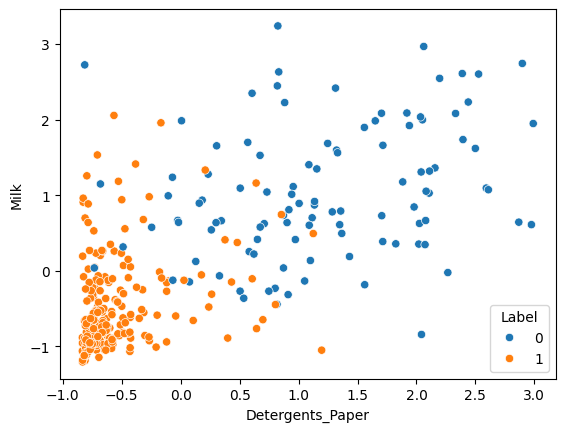

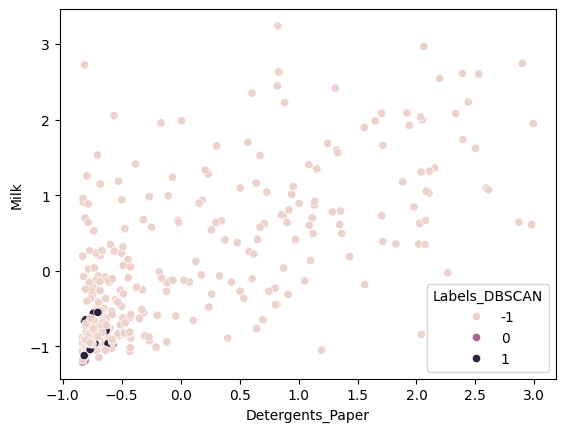

In [209]:
plot(customers_scale['Detergents_Paper'], customers_scale['Milk'], customers_scale['Label'])
plot(customers_scale['Detergents_Paper'], customers_scale['Milk'], customers_scale['Labels_DBSCAN'])

Visualice `Grocery` como X y `Fresh` como Y mediante `labels` y `labels_DBSCAN` respectivamente

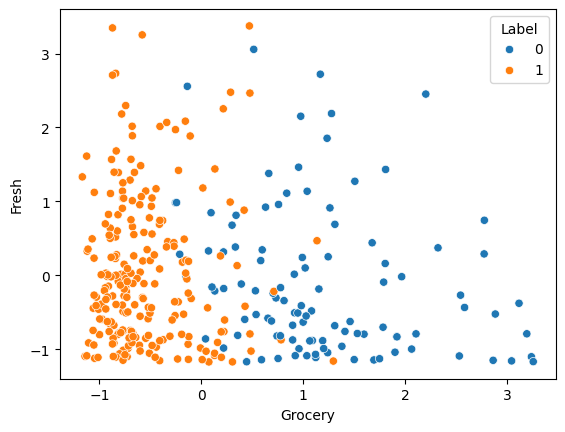

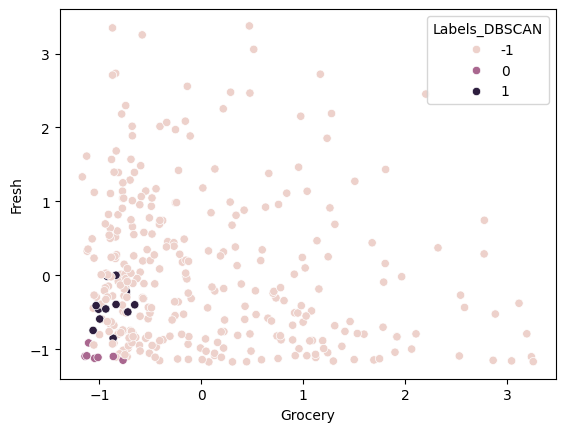

In [210]:
plot(customers_scale['Grocery'], customers_scale['Fresh'], customers_scale['Label'])
plot(customers_scale['Grocery'], customers_scale['Fresh'], customers_scale['Labels_DBSCAN'])

Visualice `Frozen` como X y `Delicassen` como Y mediante `labels` y `labels_DBSCAN` respectivamente

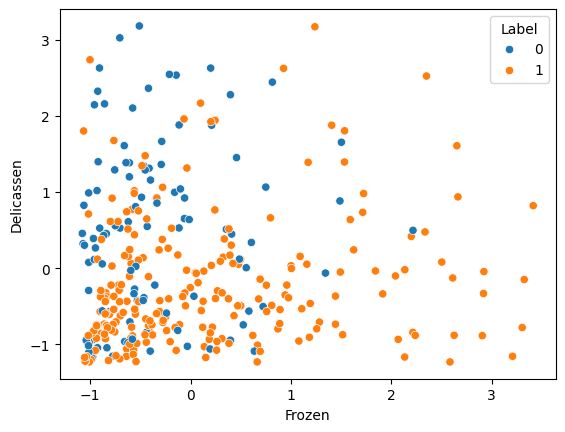

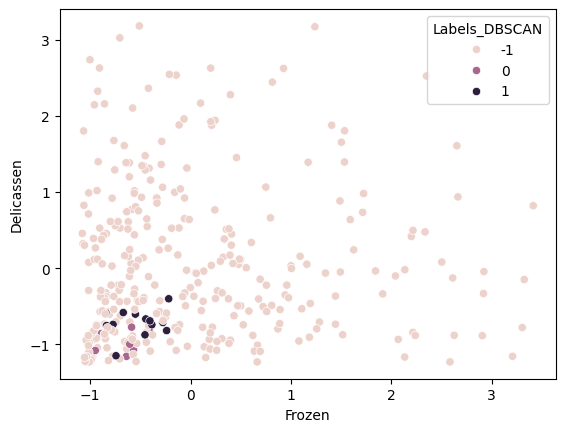

In [212]:
plot(customers_scale['Frozen'], customers_scale['Delicassen'], customers_scale['Label'])
plot(customers_scale['Frozen'], customers_scale['Delicassen'], customers_scale['Labels_DBSCAN'])

Vamos a utilizar un groupby para ver cómo la media difiere entre los grupos. Agrupamos `customers` por `labels` y `labels_DBSCAN` respectivamente y calculamos las medias de todas las columnas.

In [219]:
mean_by_kmeans = customers_scale.drop(columns=['Labels_DBSCAN']).groupby('Label').mean()

print("K-Means:")
mean_by_kmeans

K-Means:


,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Region,total_sales
Label,,,,,,,,,
0,1.305533,-0.106778,1.041965,1.182427,-0.363636,1.194316,0.448989,0.175466,0.906426
1,-0.603881,0.049391,-0.481966,-0.546937,0.168202,-0.552437,-0.207682,-0.081163,-0.419272


In [218]:
mean_by_dbscan = customers_scale.drop(columns=['Label']).groupby('Labels_DBSCAN').mean()

# Mostrar las medias calculadas
print("DBSCAN:")
mean_by_dbscan

DBSCAN:


,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Region,total_sales
Labels_DBSCAN,,,,,,,,,
-1,0.042751,0.042374,0.061229,0.060995,0.040271,0.050970,0.055763,-0.039845,0.088940
0,-0.633122,-1.082004,-1.032995,-1.008602,-0.755146,-0.801817,-1.024370,0.590092,-1.740858
1,-0.633122,-0.400309,-0.843652,-0.850663,-0.517025,-0.731361,-0.726547,0.590092,-1.105306


¿Qué algoritmo funciona mejor?
Si los datos tienen una estructura clara y bien definida, y los clústeres de K-Means son interpretables y útiles para tu análisis, K-Means podría ser el método preferido. Si hay ruido significativo y clústeres con formas variadas, DBSCAN podría ofrecer una segmentación más adecuada.

**Tus observaciones aquí**

K means identifica mejor clusters que estan mas agrupados, mientras que DBSCAN parece identificar mejor clusters mas dispersos, ademas este ultimo identifica el ruido.

# Bonus Challenge 2 - Cambiar el número de clusters de K-Means

Como hemos mencionado antes, no tenemos que preocuparnos por el número de clusters con DBSCAN porque lo decide automáticamente en función de los parámetros que le enviemos. Pero con K-Means, tenemos que suministrar el parámetro `n_clusters` (si no se suministra `n_clusters`, el algoritmo utilizará `8` por defecto). Debe saber que el número óptimo de clusters varía en función del conjunto de datos. K-Means puede funcionar mal si se utiliza un número incorrecto de clusters.

En el aprendizaje automático avanzado, los científicos de datos prueban diferentes números de clusters y evalúan los resultados con medidas estadísticas (leer [aquí](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). Hoy no vamos a utilizar medidas estadísticas, sino nuestros ojos. En las celdas de abajo, experimenta con distintos números de conglomerados y visualízalos con gráficos de dispersión. ¿Qué número de clusters parece funcionar mejor para K-Means?

In [ ]:
# Your code here


**Tus observaciones aquí**

* Viendo los gráficos del k-means ...

# Bonus Challenge 3 - Cambiar `eps` y `min_samples` de DBSCAN

Experimenta cambiando los parámetros `eps` y `min_samples` de DBSCAN. Mira cómo difieren los resultados con la visualización de gráficos de dispersión.

In [ ]:
# Your code here


**Tus observaciones aquí**

    + El DBscan ajustado...
    
